# Covid 19 Analysis

### 0) Importing tools
- - -

In [79]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

### 1) Dataset parsing and pre-processing
- - -

In [80]:
# load the dataset
df = pd.read_csv('data/covid_19_world.csv', delimiter=',')

In [81]:
# check dataframe
df

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.000000,65.000000,1/22/20,0,0,0
1,NaN,Albania,41.153300,20.168300,1/22/20,0,0,0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0,0,0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0,0,0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0,0,0
...,...,...,...,...,...,...,...,...
28243,NaN,Western Sahara,24.215500,-12.885800,5/7/20,6,0,5
28244,NaN,Sao Tome and Principe,0.186360,6.613081,5/7/20,187,4,4
28245,NaN,Yemen,15.552727,48.516388,5/7/20,25,5,1
28246,NaN,Comoros,-11.645500,43.333300,5/7/20,8,1,0


In [82]:
# observe general statistics of the dataframe
df.describe()

,Lat,Long,Confirmed,Deaths,Recovered
count,28248.000000,28248.000000,2.824800e+04,28248.000000,28248.000000
mean,21.374285,22.860921,3.496675e+03,230.362928,958.957236
std,24.754086,70.377813,3.286239e+04,2279.524686,7492.671991
min,-51.796300,-135.000000,0.000000e+00,0.000000,0.000000
25%,6.969250,-16.237775,0.000000e+00,0.000000,0.000000
50%,23.659750,20.972650,1.200000e+01,0.000000,0.000000
75%,41.166075,78.750000,2.942500e+02,3.000000,56.000000
max,71.706900,178.065000,1.257023e+06,75662.000000,195036.000000


In [83]:
# check data types of each attribute
df.dtypes

Province/State     object
Country/Region     object
Lat               float64
Long              float64
Date               object
Confirmed           int64
Deaths              int64
Recovered           int64
dtype: object

In [84]:
# convert date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

In [85]:
# observation of the data types again
df.dtypes

Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Confirmed                  int64
Deaths                     int64
Recovered                  int64
dtype: object

In [86]:
# calculate number of days since the beginning (checking for missing rows/dates)
first_day = df["Date"].min()
last_day = df["Date"].max()
total_days = len(pd.date_range(start=first_day, end=last_day))
total_days

107

In [87]:
# check the different dates the dataset has
len(df["Date"].unique())

107

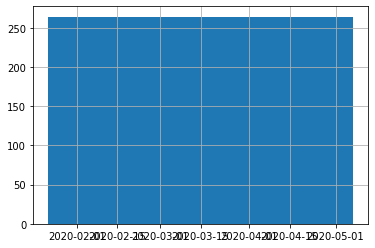

In [88]:
# creating histogram to check if any dates are missing for any country/state
df["Date"].hist(bins=len(df["Date"].unique()))

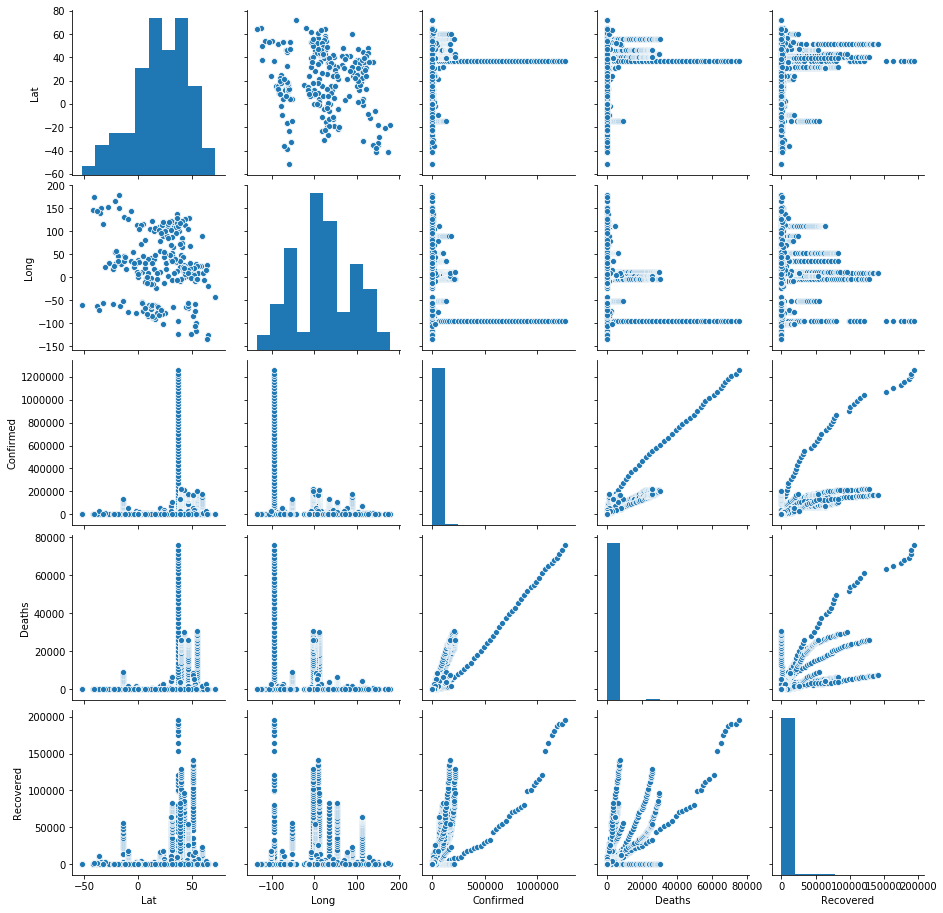

In [89]:
# compute a pairplot in order to observe the distribution of the attributes and scatter plots
sb.pairplot(df)

In [90]:
# check for missing values (null values)
df.loc[df['Date'].isnull() |
      df['Confirmed'].isnull() |
      df['Deaths'].isnull() |
      df['Recovered'].isnull() |
      df['Lat'].isnull() |
      df['Long'].isnull()]

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered


In [91]:
# check for missing values (NA values)
df.loc[df['Date'].isna() |
      df['Confirmed'].isna() |
      df['Deaths'].isna() |
      df['Recovered'].isna() |
      df['Lat'].isna() |
      df['Long'].isna()]

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered


In [92]:
# determine countries with only states data and countries with both states and total data
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

countries_with_states = df.loc[df['Province/State'].notna(), 'Country/Region'].unique()

countries_with_states_and_total = []
for country in countries_with_states:
    states_data = df.loc[(df['Country/Region'] == country) & df['Province/State'].isna()]
    if(len(states_data) > 0):
        countries_with_states_and_total.append(country)

countries_with_states_only = diff(countries_with_states, countries_with_states_and_total)
print("States only: ", end="")
print(countries_with_states_only)
print("States and Total: ", end="")
print(countries_with_states_and_total)

States only: ['Australia', 'Canada', 'China']
States and Total: ['Denmark', 'France', 'Netherlands', 'United Kingdom']


In [93]:
# remove the states data in countries with both states and total data
for country in countries_with_states_and_total:
    df = df.drop(df[(df['Country/Region'] == country) & df['Province/State'].notna()].index)
    
# transform data from countries with only states data into total country data
for country in countries_with_states_only:
    extracted = df[df['Country/Region'] == country]
    
    # country's coordinates will be the first state's coordinates
    first_lat = extracted.iloc[0]['Lat']
    first_long = extracted.iloc[0]['Long']
    
    # group rows by country and date
    summed = extracted.groupby(['Country/Region', 'Date'], as_index=False).sum()
    summed['Province/State'] = np.NaN
    summed['Province/State'] = summed['Province/State'].astype(object)
    summed['Lat'] = summed['Lat'].apply(lambda x: first_lat)
    summed['Long'] = summed['Long'].apply(lambda x: first_long)
    
    # drop state information and append new general country information
    df.drop(df[df['Country/Region'] == country].index, inplace=True)
    df = pd.concat([df, summed], ignore_index=True)
    
# delete province/state (not used anymore), and sort the values
del df["Province/State"]
df.sort_values(by=['Date', 'Country/Region'], inplace=True)

df

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,Afghanistan,33.000000,65.000000,2020-01-22,0,0,0
1,Albania,41.153300,20.168300,2020-01-22,0,0,0
2,Algeria,28.033900,1.659600,2020-01-22,0,0,0
3,Andorra,42.506300,1.521800,2020-01-22,0,0,0
4,Angola,-11.202700,17.873900,2020-01-22,0,0,0
...,...,...,...,...,...,...,...
19671,West Bank and Gaza,31.952200,35.233200,2020-05-07,375,2,176
19683,Western Sahara,24.215500,-12.885800,2020-05-07,6,0,5
19685,Yemen,15.552727,48.516388,2020-05-07,25,5,1
19661,Zambia,-15.416700,28.283300,2020-05-07,153,4,103


In [94]:
# create a column for the number of days since the starting day
df["Num_days_from_begin"] = (df["Date"] - first_day).dt.days
df

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Num_days_from_begin
0,Afghanistan,33.000000,65.000000,2020-01-22,0,0,0,0
1,Albania,41.153300,20.168300,2020-01-22,0,0,0,0
2,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0
3,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0
4,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0
...,...,...,...,...,...,...,...,...
19671,West Bank and Gaza,31.952200,35.233200,2020-05-07,375,2,176,106
19683,Western Sahara,24.215500,-12.885800,2020-05-07,6,0,5,106
19685,Yemen,15.552727,48.516388,2020-05-07,25,5,1,106
19661,Zambia,-15.416700,28.283300,2020-05-07,153,4,103,106


In [95]:
# in order to normalize the num_days_from_begin feature, that is going to be used as an input variable,
# use inverse logit to limit the range of the variable to (0, 1)
df["Num_days_from_begin_norm"] = (df['Num_days_from_begin'] / (1 + df['Num_days_from_begin'])).round(6)

# also, normalize the latitude and longitude of the dataframe entries (min-max normalization)
lat_min = -90
lat_max = 90
df["Lat"] = ((df["Lat"] - lat_min) / (lat_max - lat_min)).round(6)

long_min = -180
long_max = 180
df["Long"] = ((df["Long"] - long_min) / (long_max - long_min)).round(6)

df

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Num_days_from_begin,Num_days_from_begin_norm
0,Afghanistan,0.683333,0.680556,2020-01-22,0,0,0,0,0.000000
1,Albania,0.728629,0.556023,2020-01-22,0,0,0,0,0.000000
2,Algeria,0.655744,0.504610,2020-01-22,0,0,0,0,0.000000
3,Andorra,0.736146,0.504227,2020-01-22,0,0,0,0,0.000000
4,Angola,0.437763,0.549650,2020-01-22,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...
19671,West Bank and Gaza,0.677512,0.597870,2020-05-07,375,2,176,106,0.990654
19683,Western Sahara,0.634531,0.464206,2020-05-07,6,0,5,106,0.990654
19685,Yemen,0.586404,0.634768,2020-05-07,25,5,1,106,0.990654
19661,Zambia,0.414352,0.578565,2020-05-07,153,4,103,106,0.990654


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2d308e48>,
      dtype=object)

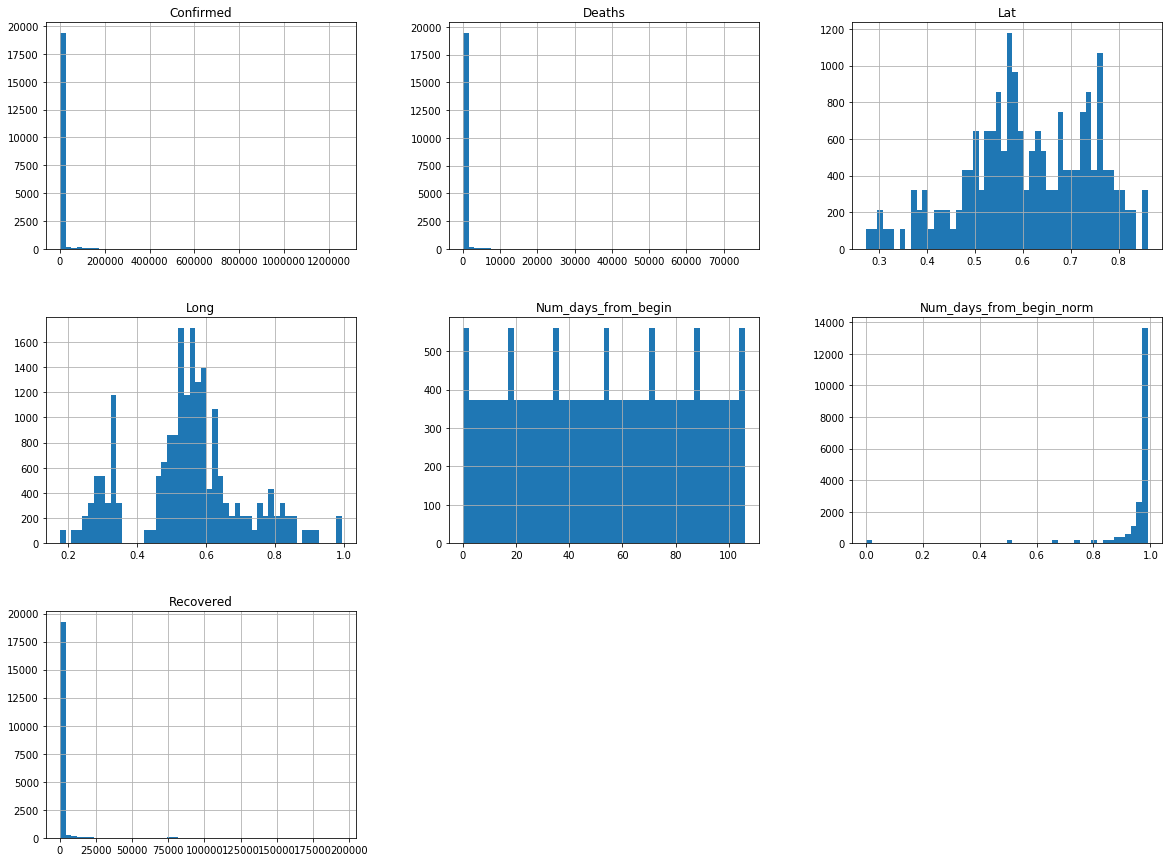

In [96]:
# compute the features's histograms
df.hist(bins=50, figsize=(20,15))

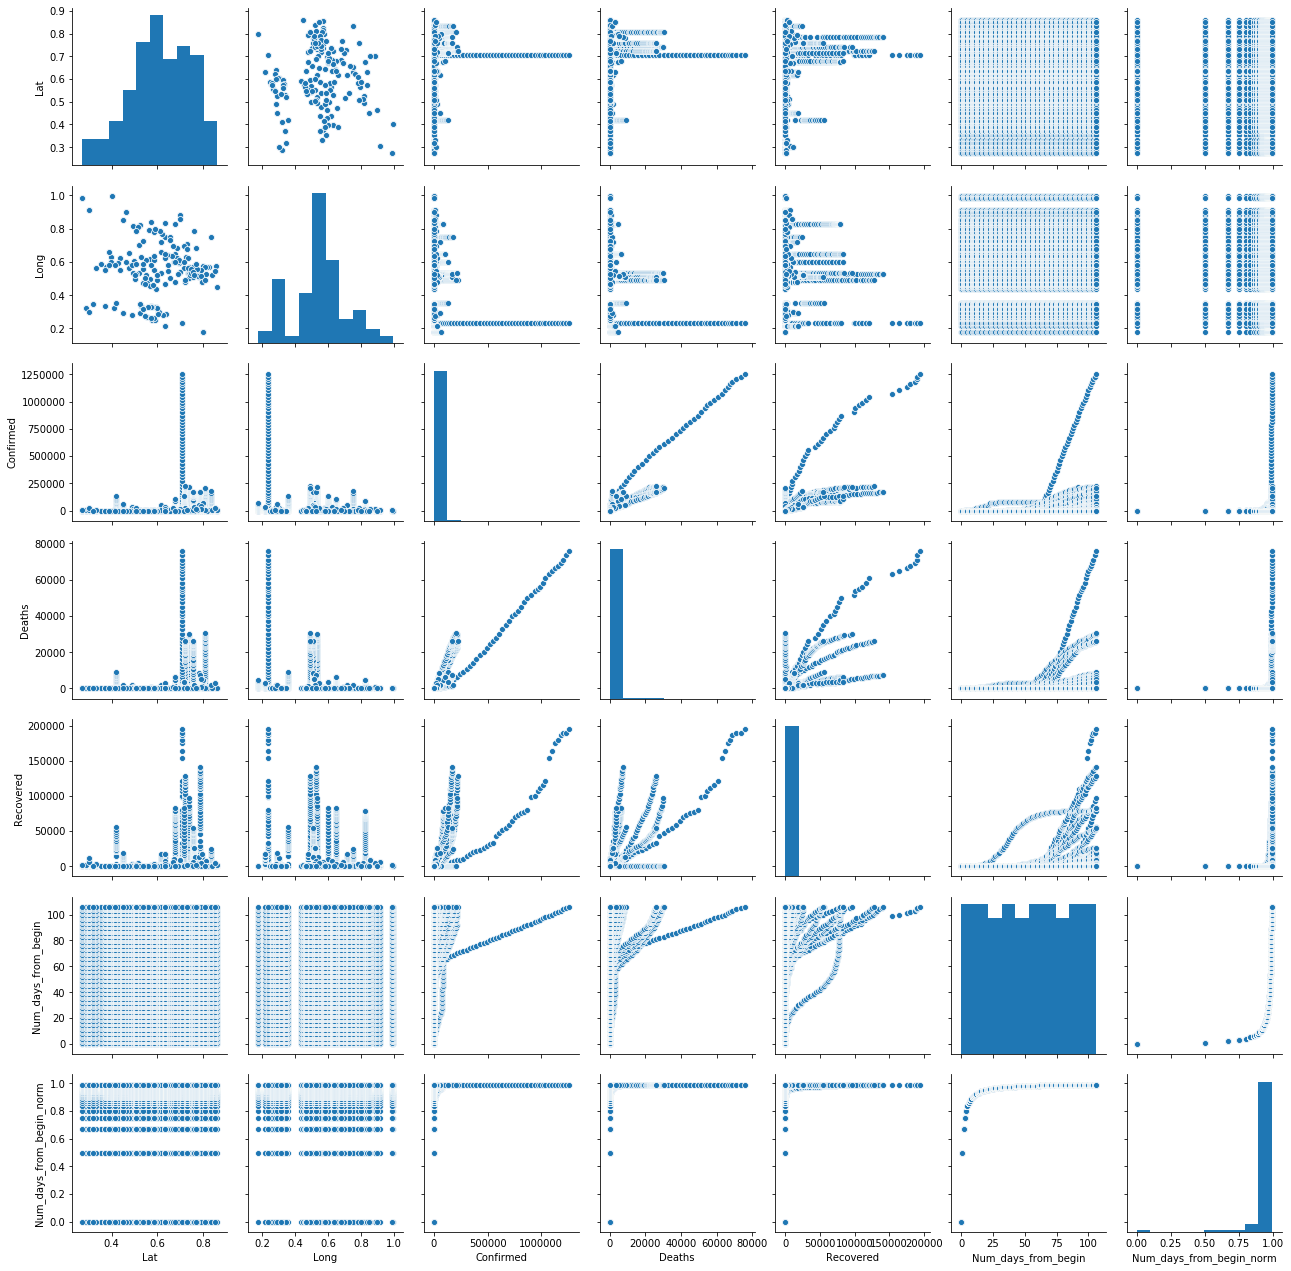

In [97]:
# compute pairplot again
sb.pairplot(df)

In [98]:
# check if all countries have information for all days (sanity check)
countries_with_dif_num_days = []

for country in df["Country/Region"].unique():
    num_dates_country = len(df.loc[df["Country/Region"] == country, "Date"].unique())
    if num_dates_country != total_days:
        countries_with_dif_num_days.append((country, num_dates_country))
        
countries_with_dif_num_days

[]

In [99]:
# rename country column and rearrange column order
df.rename(columns={"Country/Region": "Country"}, inplace=True)
cols = ["Country", "Lat", "Long", "Date", "Num_days_from_begin", "Num_days_from_begin_norm", "Confirmed", "Deaths", "Recovered"]
df = df[cols]

df

,Country,Lat,Long,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,Recovered
0,Afghanistan,0.683333,0.680556,2020-01-22,0,0.000000,0,0,0
1,Albania,0.728629,0.556023,2020-01-22,0,0.000000,0,0,0
2,Algeria,0.655744,0.504610,2020-01-22,0,0.000000,0,0,0
3,Andorra,0.736146,0.504227,2020-01-22,0,0.000000,0,0,0
4,Angola,0.437763,0.549650,2020-01-22,0,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...
19671,West Bank and Gaza,0.677512,0.597870,2020-05-07,106,0.990654,375,2,176
19683,Western Sahara,0.634531,0.464206,2020-05-07,106,0.990654,6,0,5
19685,Yemen,0.586404,0.634768,2020-05-07,106,0.990654,25,5,1
19661,Zambia,0.414352,0.578565,2020-05-07,106,0.990654,153,4,103


In [100]:
# save processed dataframe to CSV file
df.to_csv('data/covid_19_world_processed.csv', index=False)